In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Ryan Jewik\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Ryan Jewik\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('../final/o-kids-math-games.csv')

In [ ]:
df = pd.read_excel("../DeductiveAnalysis_Results.xlsx", sheet_name="o-khan-academy-kids")
df.rename(columns={'Sentence': 'review'}, inplace=True)
df.rename(columns={'Code': 'Name'}, inplace=True)

In [64]:
df['Name'].value_counts()

Name
Goal oriented                        258
Well Rounded                          89
Engaging/Fun                          73
Education                             57
Targeted                              46
Ease of Use                           41
Personalization/Variety               41
Open-Ended/Explore                    23
Boring                                22
Independence                          19
Quality Screen Time                   18
Attention/Focus                       14
Self Mastery/Growth                   14
Auditory Stimuli                      11
Cost                                   9
Reinforcement                          8
Structure                              8
Over Stimulated                        7
Travel                                 6
Calming/Stimulating                    5
Creative                               5
Adult assistance                       3
Visual Stimuli                         3
Montessori                             3
Wifi       

In [12]:
from transformers import pipeline
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

emotions dataframe by passing dataframe into roberta model

In [ ]:
#create the emotions dataframe needed for spider graphs
def analyze_app_emotions(reviews, app_name):
    emotions_df = pd.DataFrame()
    skipped_count = 0
    
    for review in reviews:
        try:
            # Get emotions for current review
            emotions = classifier(review)
            
            # Create dictionary mapping labels to scores
            row_data = {'review': review, 'Name': app_name}
            for emotion in emotions[0]:
                row_data[emotion['label']] = emotion['score']
                
            # Convert to DataFrame row and concatenate
            review_df = pd.DataFrame([row_data])
            emotions_df = pd.concat([emotions_df, review_df], ignore_index=True)
            
        except RuntimeError as e:
            skipped_count += 1
            continue
    
    return emotions_df

create 1 spider

In [ ]:
#create 1 spider
def create_emotion_spider(emotions_df, title_suffix, color, figsize):
    # Create buffer to store image
    from io import BytesIO
    import base64
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Calculate means and get top 6
    emotion_means = emotions_df.drop(['review', 'Name'], axis=1).mean()
    top_emotions = dict(sorted(emotion_means.items(), key=lambda x: x[1], reverse=True)[:6])
    
    # Prepare data
    emotions = [emotion.capitalize() for emotion in top_emotions.keys()]
    values = list(top_emotions.values())
    
    # Setup angles
    num_vars = len(emotions)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    values += values[:1]
    
    # Plot data
    ax.plot(angles, values, 'o-', linewidth=2, color=color, label='Top 6 Emotions')
    ax.fill(angles, values, alpha=0.25, color=color)
    
    # Customize chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions, size=10)
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5])
    
    plt.title(f"Emotional Analysis: {title_suffix}", size=15, y=1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    
    # Save plot to buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_png = buffer.getvalue()
    graph = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    plt.show()
    # Clear the current figure
    plt.close()
    
    # Encode
    
    
    return graph

combining multiple spiders

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

def create_combined_emotion_spider(df1, df2, df3, title_suffix, colors, figsize=(10, 10)):
    # Combine the dataframes
    combined_df = pd.concat([df1, df2, df3])
    labels = []
    labels.append(df1['Name'].iloc[0])
    labels.append(df2['Name'].iloc[0])
    labels.append(df3['Name'].iloc[0])
    
    # Calculate means and get top 6 emotions
    emotion_means = combined_df.drop(['review', 'Name'], axis=1).mean()
    top_emotions = dict(sorted(emotion_means.items(), key=lambda x: x[1], reverse=True)[:6])
    
    # Prepare data
    emotions = [emotion.capitalize() for emotion in top_emotions.keys()]
    num_vars = len(emotions)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
    
    # Plot each dataframe
    for i, df in enumerate([df1, df2, df3]):
        emotion_means = df.drop(['review', 'Name'], axis=1).mean()
        values = [emotion_means.get(emotion.lower(), 0) for emotion in emotions]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=labels[i - 1])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Customize chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions, size=10)
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5])
    
    plt.title(f"Emotional Analysis: {title_suffix}", size=15, y=1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    
    # Save plot to buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_png = buffer.getvalue()
    graph = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    plt.show()
    plt.close()
    
    return graph

In [26]:
df['Name'].value_counts()

Name
Engaging/Fun               188
Goal oriented               67
Creative                    36
Education                   35
Ease of Use                 31
Personalization/Variety     31
Other                       28
Boring                      25
Open-Ended/Explore          12
Unclassified                10
Well Rounded                 9
Visual Stimuli               9
Fine Motor Skills            8
Auditory Stimuli             8
Targeted                     7
Wifi                         6
Self Mastery/Growth          4
Age Appropriateness          2
Tactile Stimuli              2
Reinforcement                2
Over Stimulated              1
Cost                         1
Travel                       1
Quality Screen Time          1
Family                       1
Name: count, dtype: int64

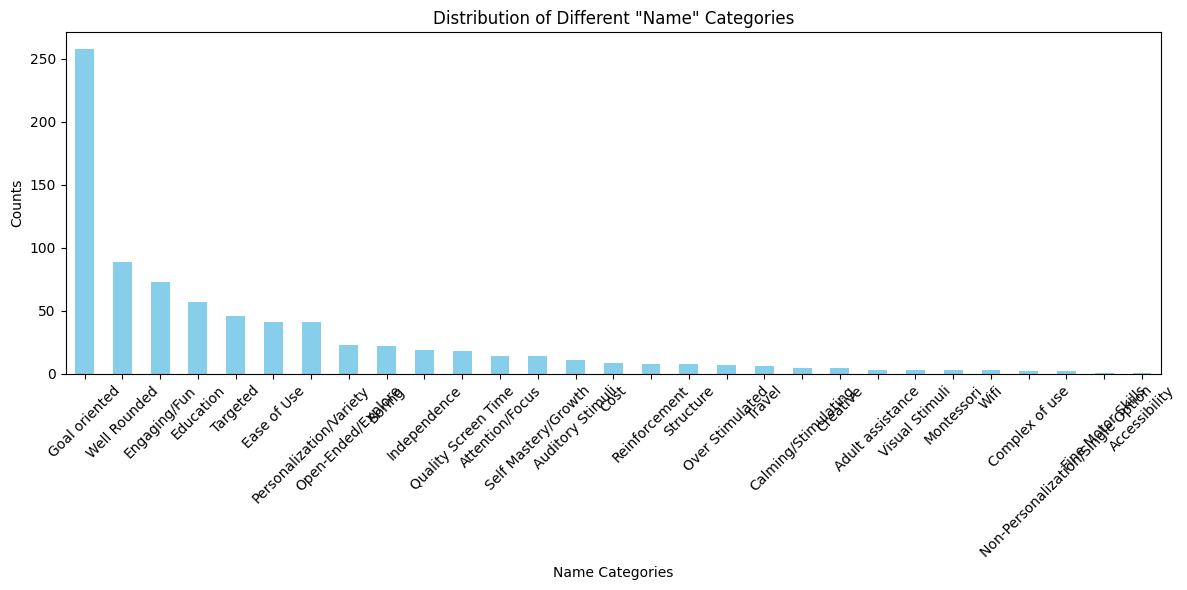

In [68]:
# Calculate the value counts for the 'Name' column
name_counts = df['Name'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 6))
name_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Different "Name" Categories')
plt.xlabel('Name Categories')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an image file
plt.savefig('name_distribution.png')

# Show the plot
plt.show()

In [88]:
# Get the top 3 most common "Name" values
top_6_codes = name_counts.head(6).index.tolist()

# Print the top 3 names
print(top_6_codes)

['Goal oriented', 'Well Rounded', 'Engaging/Fun', 'Education', 'Targeted', 'Ease of Use']


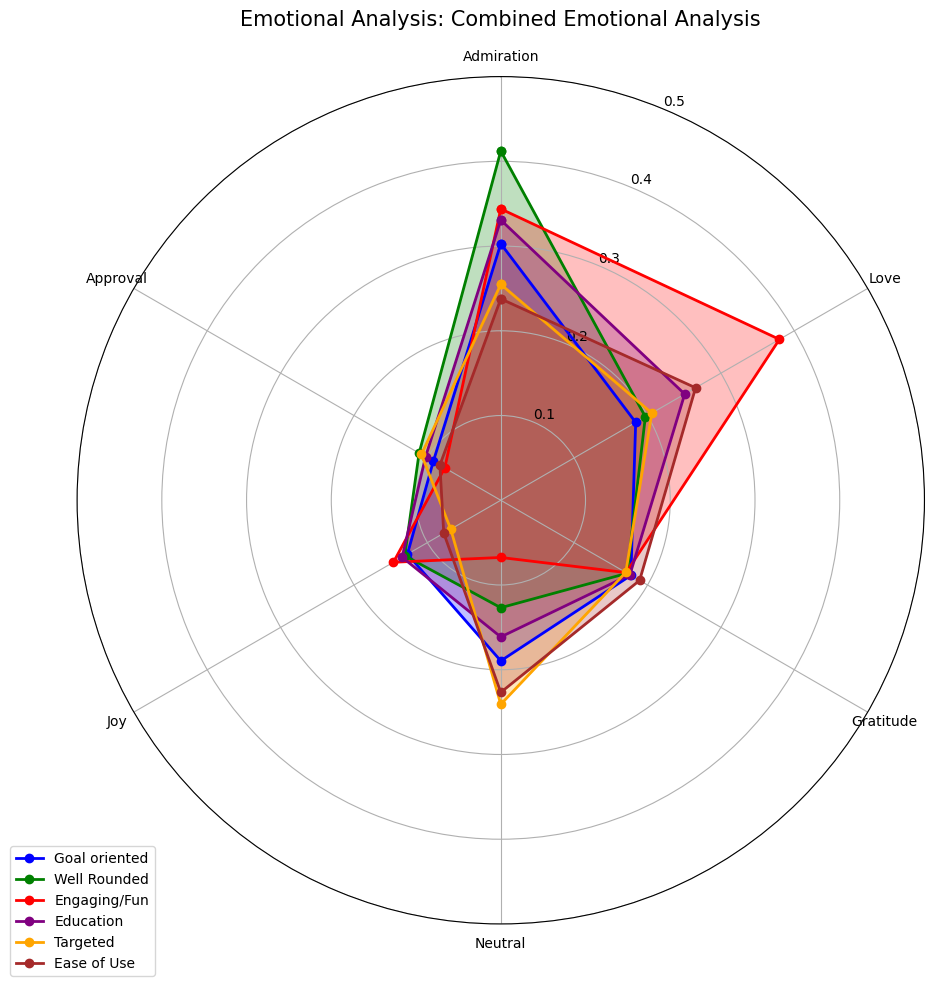

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

def create_combined_emotion_spider(dfs, title_suffix, colors, figsize=(10, 10)):
    # Combine the dataframes
    combined_df = pd.concat(dfs)
    
    # Get the labels for each dataframe
    labels = [df['Name'].iloc[0] for df in dfs]
    
    # Calculate means and get top 6 emotions
    emotion_means = combined_df.drop(['review', 'Name'], axis=1).mean()
    top_emotions = dict(sorted(emotion_means.items(), key=lambda x: x[1], reverse=True)[:6])
    
    # Prepare data
    emotions = [emotion.capitalize() for emotion in top_emotions.keys()]
    num_vars = len(emotions)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
    
    # Plot each dataframe
    for i, df in enumerate(dfs):
        emotion_means = df.drop(['review', 'Name'], axis=1).mean()
        values = [emotion_means.get(emotion.lower(), 0) for emotion in emotions]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=labels[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Customize chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions, size=10)
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5])
    
    plt.title(f"Emotional Analysis: {title_suffix}", size=15, y=1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    
    # Save plot to buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_png = buffer.getvalue()
    graph = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    plt.show()
    plt.close()
    
    return graph

# Example usage
# Example usage
df1 = df[df['Name'] == top_6_codes[0]]
emotion_df1 = analyze_app_emotions(df1['review'], df1['Name'].iloc[0])
df2 = df[df['Name'] == top_6_codes[1]]
emotion_df2 = analyze_app_emotions(df2['review'], df2['Name'].iloc[0])
df3 = df[df['Name'] == top_6_codes[2]]
emotion_df3 = analyze_app_emotions(df3['review'], df3['Name'].iloc[0])
df4 = df[df['Name'] == top_6_codes[3]]
emotion_df4 = analyze_app_emotions(df4['review'], df4['Name'].iloc[0])
df5 = df[df['Name'] == top_6_codes[4]]
emotion_df5 = analyze_app_emotions(df5['review'], df5['Name'].iloc[0])
df6 = df[df['Name'] == top_6_codes[5]]
emotion_df6 = analyze_app_emotions(df6['review'], df6['Name'].iloc[0])

# Assuming the dataframes have a 'review' and 'Name' column, and emotion columns
img = create_combined_emotion_spider([emotion_df1, emotion_df2, emotion_df3, emotion_df4, emotion_df5, emotion_df6], 'Combined Emotional Analysis', ['blue', 'green', 'red', 'purple', 'orange', 'brown'])

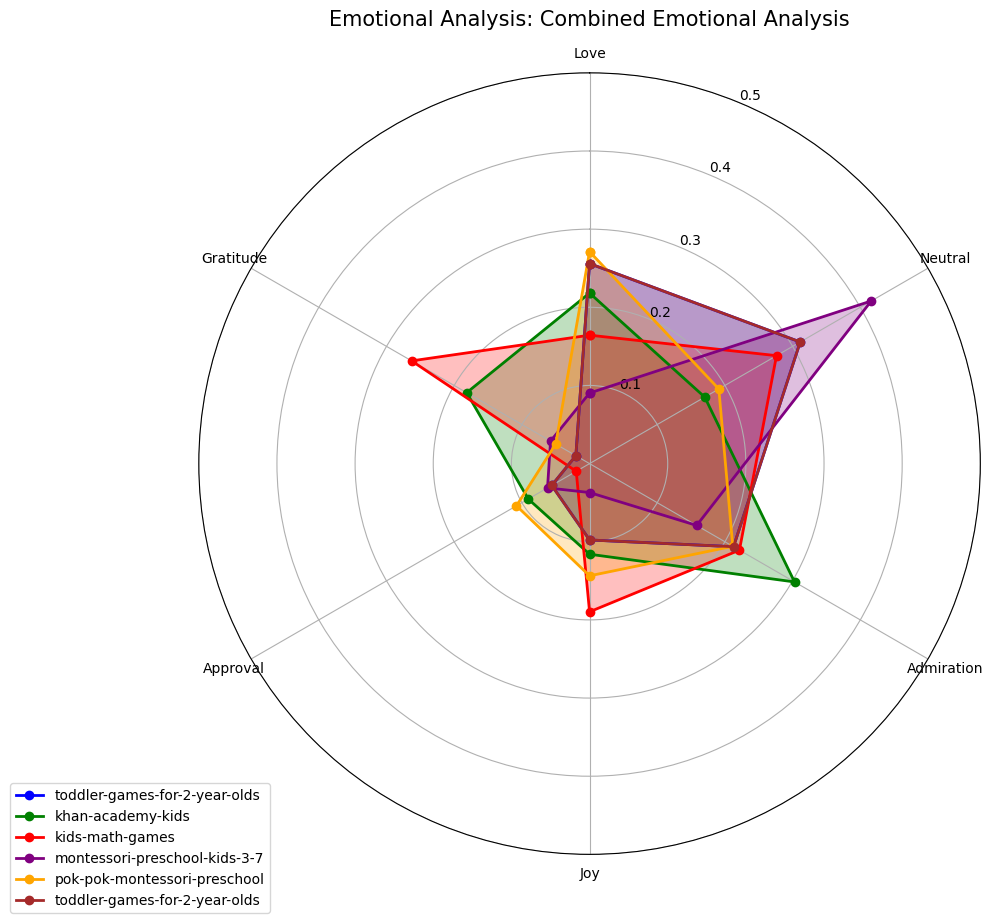

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from io import BytesIO
import base64

# Initialize the classifier
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

# Function to analyze emotions in reviews
def analyze_app_emotions(reviews, app_name):
    emotions_df = pd.DataFrame()
    skipped_count = 0
    
    for review in reviews:
        try:
            # Ensure the review is a string
            review = str(review)
            
            # Get emotions for current review
            emotions = classifier(review)
            
            # Create dictionary mapping labels to scores
            row_data = {'review': review, 'Name': app_name}
            for emotion in emotions[0]:
                row_data[emotion['label']] = emotion['score']
                
            # Convert to DataFrame row and concatenate
            review_df = pd.DataFrame([row_data])
            emotions_df = pd.concat([emotions_df, review_df], ignore_index=True)
            
        except RuntimeError as e:
            skipped_count += 1
            continue
    
    return emotions_df

# Function to create combined emotion spider graph
def create_combined_emotion_spider(dfs, labels, title_suffix, colors, figsize=(10, 10)):
    # Combine the dataframes
    combined_df = pd.concat(dfs)
    
    # Calculate means and get top 6 emotions
    emotion_means = combined_df.drop(['review', 'Name'], axis=1).mean()
    top_emotions = dict(sorted(emotion_means.items(), key=lambda x: x[1], reverse=True)[:6])
    
    # Prepare data
    emotions = [emotion.capitalize() for emotion in top_emotions.keys()]
    num_vars = len(emotions)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
    
    # Plot each dataframe
    for i, df in enumerate(dfs):
        emotion_means = df.drop(['review', 'Name'], axis=1).mean()
        values = [emotion_means.get(emotion.lower(), 0) for emotion in emotions]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=labels[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Customize chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions, size=10)
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5])
    
    plt.title(f"Emotional Analysis: {title_suffix}", size=15, y=1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    
    # Save plot to buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_png = buffer.getvalue()
    graph = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    plt.show()
    plt.close()
    
    return graph

# Example usage
labels = [
    "toddler-games-for-2-year-olds",
    "khan-academy-kids",
    "kids-math-games",
    "montessori-preschool-kids-3-7",
    "pok-pok-montessori-preschool",
    "toddler-games-for-2-year-olds"
]

# Load dataframes and analyze emotions
dfs = []
for label in labels:
    df = pd.read_excel("../DeductiveAnalysis_Results.xlsx", sheet_name=f"o-{label}")
    df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
    emotion_df = analyze_app_emotions(df['review'], label)
    dfs.append(emotion_df)

# Create combined spider graph
img = create_combined_emotion_spider(dfs, labels, 'Combined Emotional Analysis', ['blue', 'green', 'red', 'purple', 'orange', 'brown'])

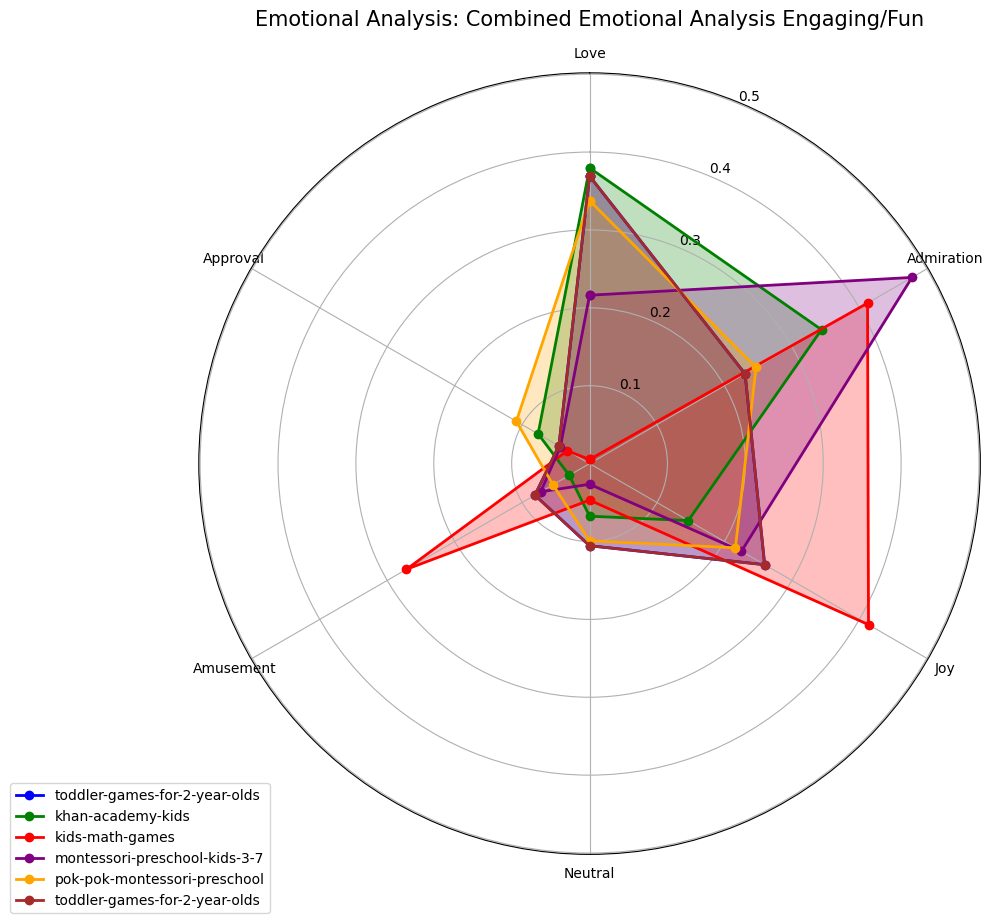

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from io import BytesIO
import base64

# Initialize the classifier
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

# Function to analyze emotions in reviews
def analyze_app_emotions(reviews, app_name):
    emotions_df = pd.DataFrame()
    skipped_count = 0
    
    for review in reviews:
        try:
            # Ensure the review is a string
            review = str(review)
            
            # Get emotions for current review
            emotions = classifier(review)
            
            # Create dictionary mapping labels to scores
            row_data = {'review': review, 'Name': app_name}
            for emotion in emotions[0]:
                row_data[emotion['label']] = emotion['score']
                
            # Convert to DataFrame row and concatenate
            review_df = pd.DataFrame([row_data])
            emotions_df = pd.concat([emotions_df, review_df], ignore_index=True)
            
        except RuntimeError as e:
            skipped_count += 1
            continue
    
    return emotions_df

# Function to create combined emotion spider graph
def create_combined_emotion_spider(dfs, labels, title_suffix, colors, figsize=(10, 10)):
    # Combine the dataframes
    combined_df = pd.concat(dfs)
    
    # Calculate means and get top 6 emotions
    emotion_means = combined_df.drop(['review', 'Name'], axis=1).mean()
    top_emotions = dict(sorted(emotion_means.items(), key=lambda x: x[1], reverse=True)[:6])
    
    # Prepare data
    emotions = [emotion.capitalize() for emotion in top_emotions.keys()]
    num_vars = len(emotions)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
    
    # Plot each dataframe
    for i, df in enumerate(dfs):
        emotion_means = df.drop(['review', 'Name'], axis=1).mean()
        values = [emotion_means.get(emotion.lower(), 0) for emotion in emotions]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=labels[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Customize chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions, size=10)
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5])
    
    plt.title(f"Emotional Analysis: {title_suffix}", size=15, y=1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    
    # Save plot to buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_png = buffer.getvalue()
    graph = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    plt.show()
    plt.close()
    
    return graph

# Example usage
labels = [
    "toddler-games-for-2-year-olds",
    "khan-academy-kids",
    "kids-math-games",
    "montessori-preschool-kids-3-7",
    "pok-pok-montessori-preschool",
    "toddler-games-for-2-year-olds"
]

# Load dataframes and analyze emotions
dfs = []
big_df = pd.DataFrame()

for label in labels:
    df = pd.read_excel("../DeductiveAnalysis_Results.xlsx", sheet_name=f"o-{label}")
    df.rename(columns={'Code': 'Name'}, inplace=True)
    df = df['Name']
    big_df = pd.concat([big_df, df])
    

code_counts = big_df['Name'].value_counts()
# Get the top 3 most common "Name" values
top_6_codes = code_counts.head(6).index.tolist()

for label in labels:
    df = pd.read_excel("../DeductiveAnalysis_Results.xlsx", sheet_name=f"o-{label}")
    df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
    emotion_df = analyze_app_emotions(df[df['Name'] == top_6_codes[0]]['review'], label)
    dfs.append(emotion_df)
    big_df = pd.concat([big_df, emotion_df])




# Create combined spider graph
img = create_combined_emotion_spider(dfs, labels, f'Combined Emotional Analysis {top_6_codes[0]}', ['blue', 'green', 'red', 'purple', 'orange', 'brown'])